In [2]:
print('Welcome to facial-emotion.')

Welcome to facial-emotion.


In [3]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot
import seaborn as sns
from keras.api.utils import to_categorical
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
df = pd.read_csv('data/fer2013.csv')

r, c = df.shape
print(f'The dataset has {r} rows and {c} columns.\n')
df.head()

The dataset has 35887 rows and 3 columns.



,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [6]:
df['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [7]:
df['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [8]:
emotion_label_to_text = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [9]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

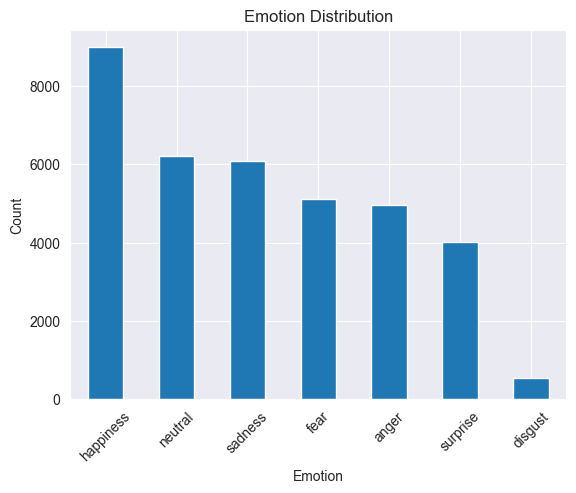

In [10]:
df['emotion'].map(emotion_label_to_text).value_counts().plot(kind='bar')

plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution')
plt.xticks(rotation=45)  # Rotate the x-axis labels if needed for better visibility

plt.show()

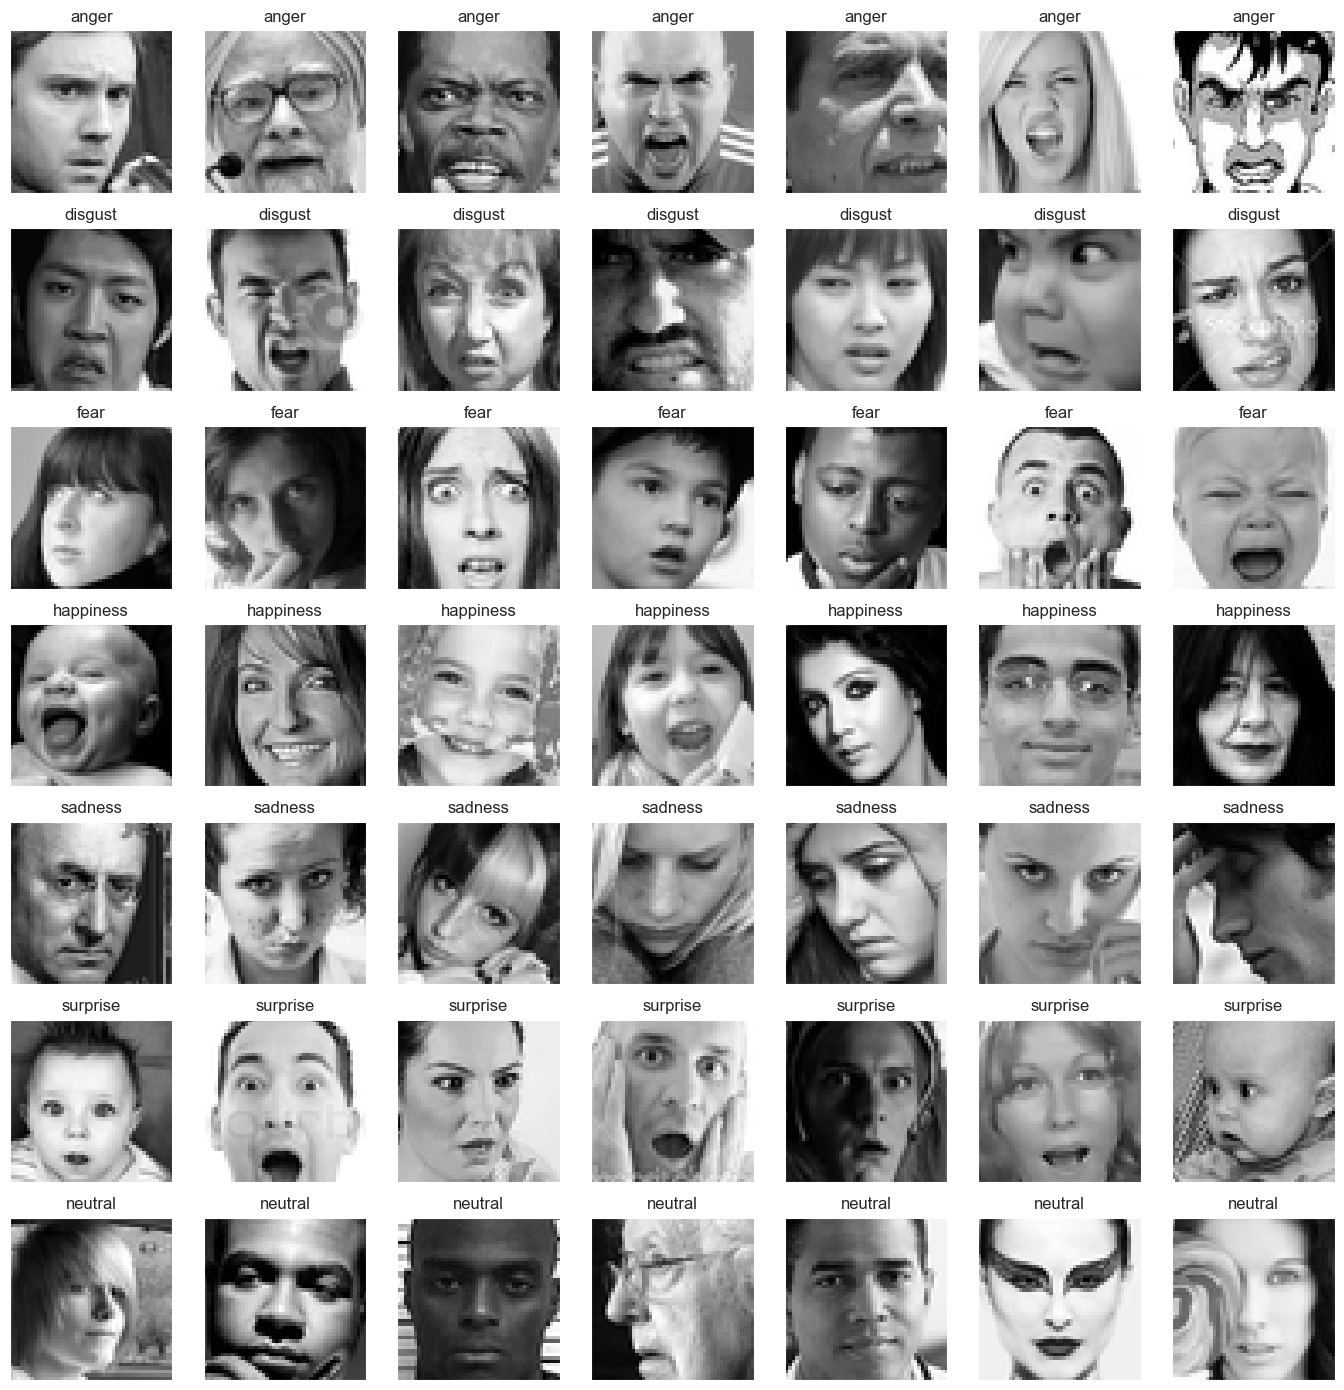

In [11]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [12]:
math.sqrt(len(df.pixels[2].split(' ')))

48.0

In [13]:
pixel_length = int(math.sqrt(len(df.pixels[1].split(' '))))

pixel_length

48

In [14]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(pixel_length, pixel_length, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

img_array.shape

(35887, 48, 48, 1)

In [15]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)

img_labels.shape

(35887, 7)

In [16]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

le_name_mapping

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

In [17]:
X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [18]:
# del df
# del img_array
# del img_labels

In [19]:
_, img_width, img_height, img_depth = X_train.shape
num_classes = y_train.shape[1]

img_width, img_height, img_depth, num_classes

(48, 48, 1, 7)

In [20]:
# np.random.seed(42)
# surprise_idx = np.random.choice(np.where(y_train[:, 0] == 1)[0], size=1)
# happy_idx = np.random.choice(np.where(y_train[:, 1] == 1)[0], size=1)
# anger_idx = np.random.choice(np.where(y_train[:, 2] == 1)[0], size=1)
# sad_idx = np.random.choice(np.where(y_train[:, 3] == 1)[0], size=1)
# fear_idx = np.random.choice(np.where(y_train[:, 4] == 1)[0], size=1)
#
# fig = plt.figure(1, (6, 13))
#
# i = 0
# for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
#     for j in range(3):
#         i += 1
#         ax = plt.subplot(5, 3, i)
#         sample_img = X_train[idx][0, j, :, :, 0]
#         ax.imshow(sample_img, cmap='gray')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_title(name)

In [21]:
# Normalizing results, as neural networks are very sensitive to un-normalized data.
X_train = X_train / 255.
X_valid = X_test / 255.

X_train.mean(), X_train.std(), X_valid.mean(), X_valid.std()

(0.5075212, 0.2551314, 0.5062769, 0.25510627)

In [22]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    at least in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    # Use Input layer for defining the input shape
    net.add(
        Input(shape=(img_width, img_height, img_depth), name='input_layer')
    )

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5, 5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5, 5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net


In [23]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [24]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32  # batch size of 32 performs the best.
epochs = 10  # should be 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1])
# history = model.fit_generator(
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    # workers=4,
    # use_multiprocessing=True,
    # max_queue_size=10
)

Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,591 (9.14 MB)

 Trainable params: 2,393,543 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/10


/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 903/1009 ━━━━━━━━━━━━━━━━━━━━ 45s 426ms/step - accuracy: 0.2038 - loss: 2.3457

In [ ]:
model.save("facial-model.keras")

In [ ]:
sns.set()

# Create the figure and subplots
fig = plt.figure(figsize=(12, 4))

# Accuracy plot
ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

# Loss plot
ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

# Save the plot and display it
plt.savefig('epoch_history_dcnn.png')
plt.show()


In [ ]:
# Create dataframes for accuracy and loss
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

# Create the figure and subplots
fig = plt.figure(figsize=(14, 4))

# Accuracy plot
ax = plt.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu))
plt.title('Accuracy')
plt.tight_layout()

# Loss plot
ax = plt.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss))
plt.title('Loss')
plt.tight_layout()

# Save the plot and display it
plt.savefig('performance_dist.png')
plt.show()


In [ ]:
# Predict probabilities for each class using the model
yhat_test = model.predict(X_test)

# Convert probabilities to class labels
yhat_test_classes = np.argmax(yhat_test, axis=1)

# Plot confusion matrix
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_test_classes, figsize=(7, 7))
plt.savefig("confusion_matrix_dcnn.png")

# Print the number of incorrect predictions
print(f'Total wrong test predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_test_classes)}\n\n')

# Print classification report with zero_division parameter to handle the warning
print(classification_report(np.argmax(y_test, axis=1), yhat_test_classes, zero_division=0))


In [ ]:
# Set the random seed for reproducibility
np.random.seed(2)

# Randomly select sad and neutral images
random_sad_imgs = np.random.choice(np.where(y_test[:, 4] == 1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_test[:, 6] == 1)[0], size=9)

# Create the figure
fig = plt.figure(1, (18, 4))

# Loop through the selected indices
for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    # Plot sad images
    ax = plt.subplot(2, 9, i + 1)
    sample_img = X_valid[sadidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Predict and get the label for sad images
    pred_sad = model.predict(sample_img.reshape(1, 48, 48, 1))
    predicted_label_sad = emotion_label_to_text[np.argmax(pred_sad)]  # Use np.argmax to get the predicted class index
    ax.set_title(f"true:sad, pred:{predicted_label_sad}")

    # Plot neutral images
    ax = plt.subplot(2, 9, i + 10)
    sample_img = X_valid[neuidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Predict and get the label for neutral images
    pred_neutral = model.predict(sample_img.reshape(1, 48, 48, 1))
    predicted_label_neutral = emotion_label_to_text[
        np.argmax(pred_neutral)]  # Use np.argmax to get the predicted class index
    ax.set_title(f"t:neut, p:{predicted_label_neutral}")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:



def plot_random_emotion_predictions(model, X_valid, y_test, emotion_label_to_text, emotion_name, n_images=9, seed=2):
    # Ensure reproducibility with the random seed
    np.random.seed(seed)

    # Find the index of the emotion in the label dictionary
    emotion_idx = [idx for idx, label in emotion_label_to_text.items() if label == emotion_name]

    if not emotion_idx:
        print(f"Emotion '{emotion_name}' not found in the emotion_label_to_text dictionary.")
        return

    emotion_idx = emotion_idx[0]  # Get the first index (since the dictionary is unique)

    # Select random indices for the chosen emotion
    random_emotion_imgs = np.random.choice(np.where(y_test[:, emotion_idx] == 1)[0], size=n_images)

    # Create the figure for plotting
    fig = plt.figure(figsize=(18, 4))

    # Loop through the selected indices and plot
    for i, idx in enumerate(random_emotion_imgs):
        # Plot the image
        ax = plt.subplot(1, n_images, i + 1)
        sample_img = X_valid[idx, :, :, 0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        # Predict and get the label for the current image
        pred = model.predict(sample_img.reshape(1, 48, 48, 1))
        predicted_label = emotion_label_to_text[np.argmax(pred)]  # Get predicted label using np.argmax

        # Set the title with the predicted label
        ax.set_title(f"pred:{predicted_label}")

        # Add the emotion name at the bottom of the image
        ax.text(0.5, -0.1, f"emotion:{emotion_name}", ha='center', va='center', transform=ax.transAxes, fontsize=10)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


for emotion in emotion_label_to_text.values():
    # Call the function to plot for the emotion "--"
    plot_random_emotion_predictions(model, X_valid, y_test, emotion_label_to_text, emotion_name=emotion, n_images=9,
                                    seed=2)
    # break



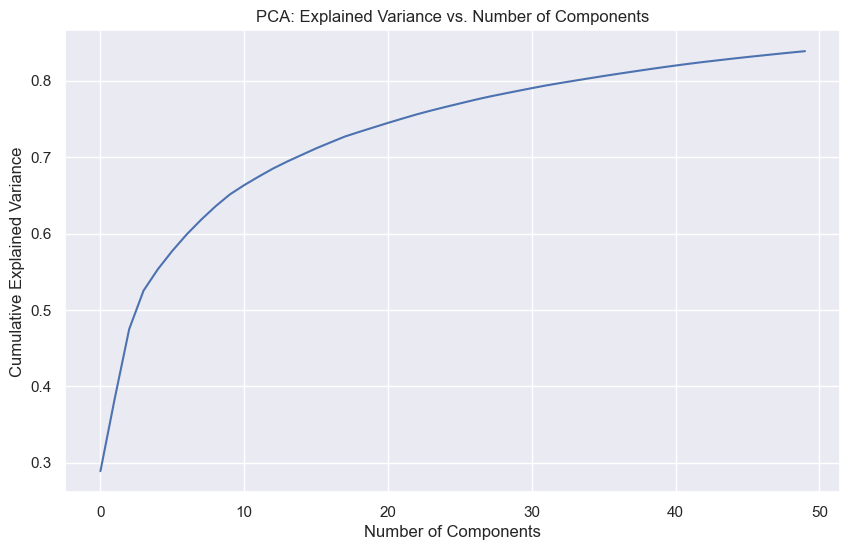

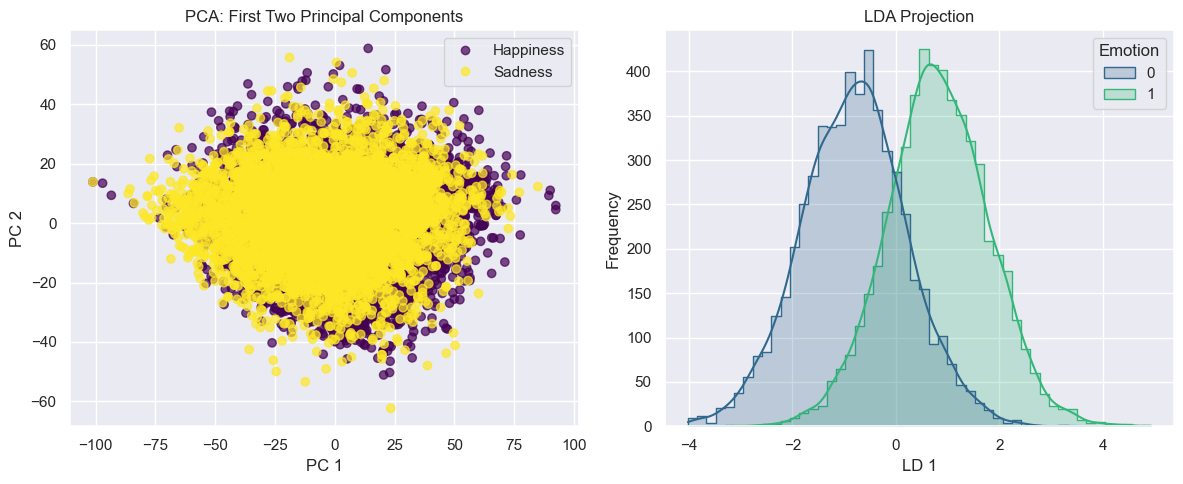

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       899
           1       0.40      1.00      0.57       608

    accuracy                           0.40      1507
   macro avg       0.20      0.50      0.29      1507
weighted avg       0.16      0.40      0.23      1507

Naive Bayes Accuracy: 0.40345056403450563


/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

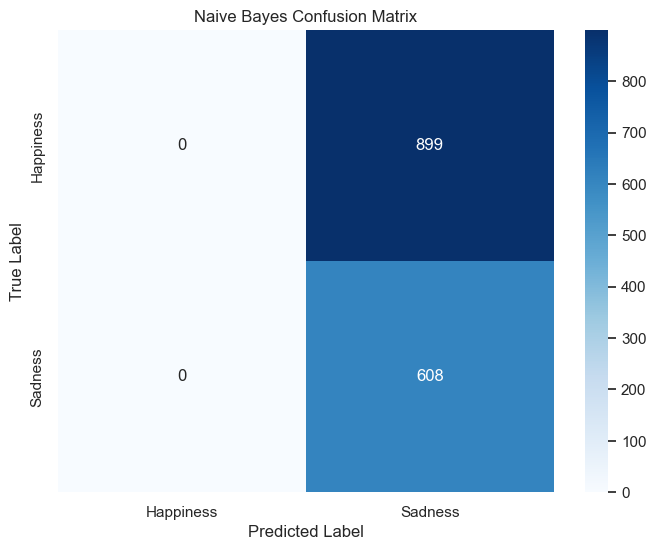

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.97      0.76       899
           1       0.77      0.14      0.24       608

    accuracy                           0.64      1507
   macro avg       0.70      0.56      0.50      1507
weighted avg       0.68      0.64      0.55      1507

Logistic Regression Accuracy: 0.6370272063702721


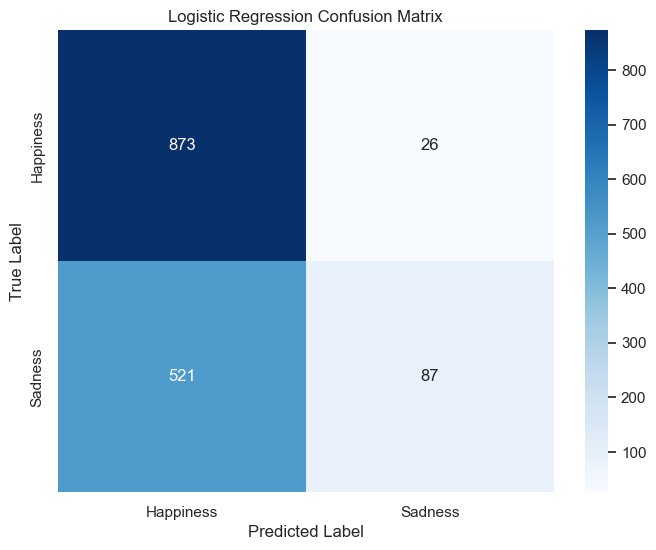

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       899
           1       0.40      1.00      0.57       608

    accuracy                           0.40      1507
   macro avg       0.20      0.50      0.29      1507
weighted avg       0.16      0.40      0.23      1507

SVM Accuracy: 0.40345056403450563


/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

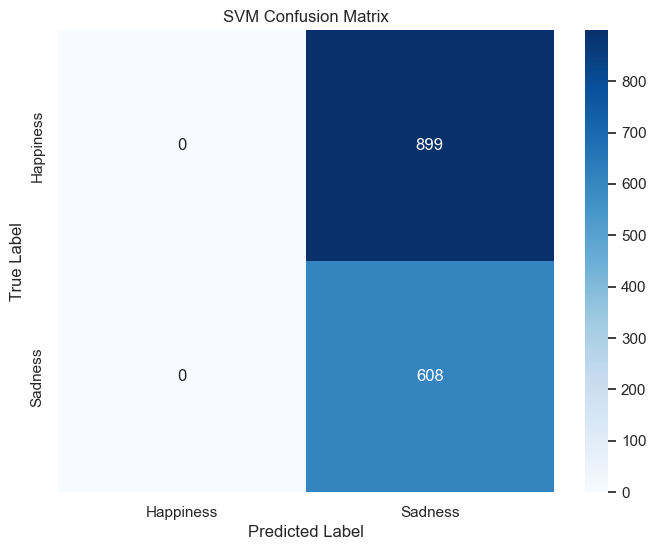

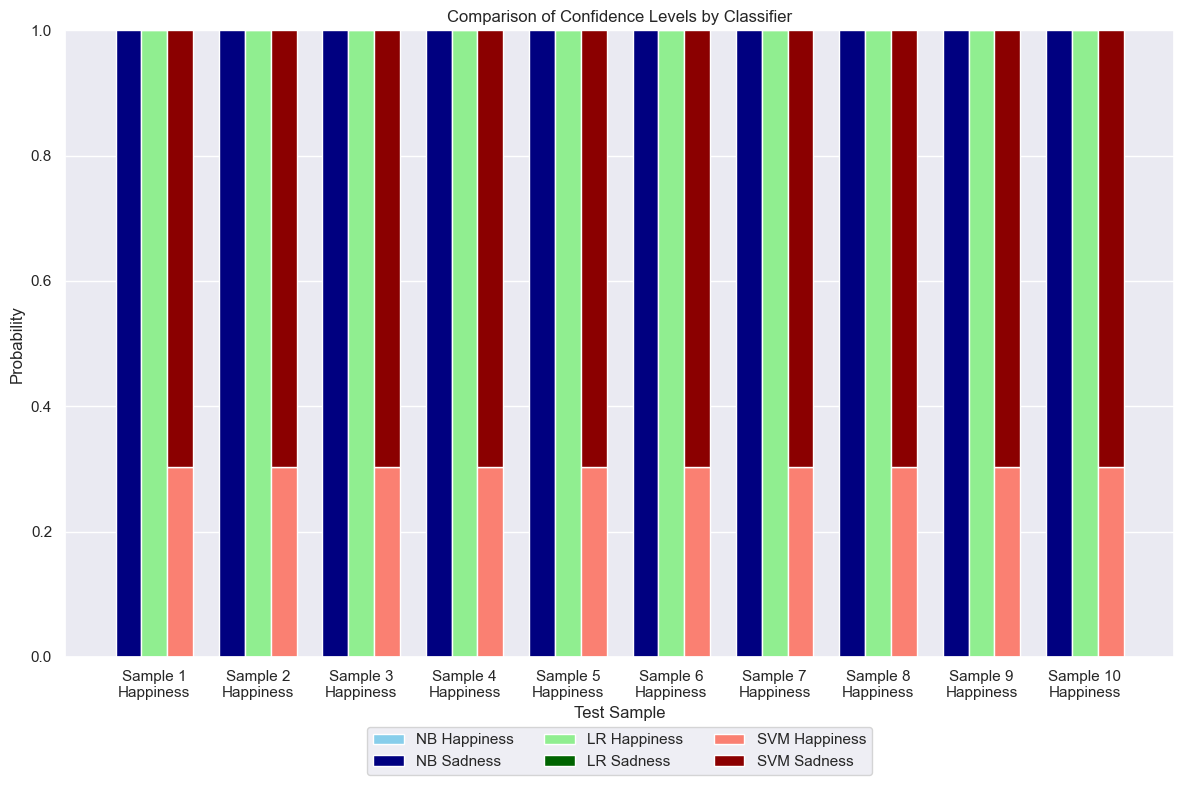

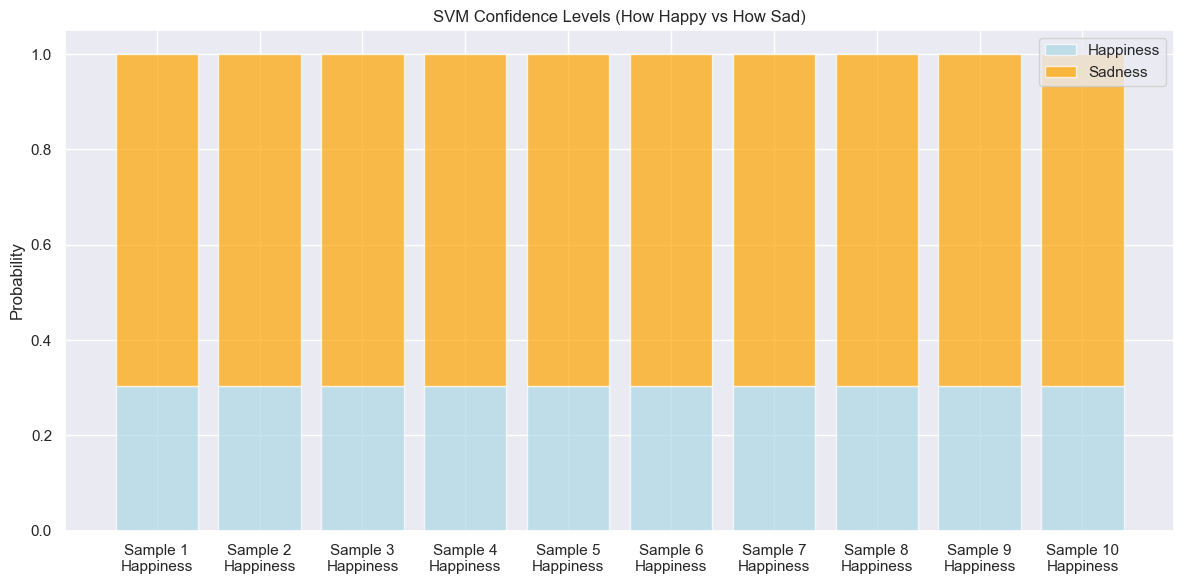

In [66]:
# Part I of the assignment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Step 1: Sample a subset of the data based on class label
# Let's choose happiness (3) and sadness (4) as our two classes for Part I

# Extract features from the existing dataset
# Assuming df, emotion_label_to_text, X_train, y_train, X_test, y_test are already defined

# Get indices for happiness and sadness from training data
happiness_indices = np.where(np.argmax(y_train, axis=1) == 3)[0]
sadness_indices = np.where(np.argmax(y_train, axis=1) == 4)[0]

# Sample equal amounts from each class (use the smaller class size)
sample_size = min(len(happiness_indices), len(sadness_indices))
happiness_sample = np.random.choice(happiness_indices, size=sample_size, replace=False)
sadness_sample = np.random.choice(sadness_indices, size=sample_size, replace=False)

# Combine indices and extract the subset
subset_indices = np.concatenate([happiness_sample, sadness_sample])
X_subset = X_train[subset_indices].reshape(len(subset_indices), -1)  # Flatten images
y_subset = np.argmax(y_train[subset_indices], axis=1)
# Convert class labels 3 and 4 to binary labels 0 and 1
y_subset = np.where(y_subset == 3, 0, 1)  # happiness = 0, sadness = 1

# Do the same for test data
happiness_test_indices = np.where(np.argmax(y_test, axis=1) == 3)[0]
sadness_test_indices = np.where(np.argmax(y_test, axis=1) == 4)[0]
test_indices = np.concatenate([happiness_test_indices, sadness_test_indices])
X_test_subset = X_test[test_indices].reshape(len(test_indices), -1)
y_test_subset = np.argmax(y_test[test_indices], axis=1)
y_test_subset = np.where(y_test_subset == 3, 0, 1)

# Step 2: Apply PCA and LDA and visualize the results
# Standardize the data
scaler = StandardScaler()
X_subset_scaled = scaler.fit_transform(X_subset)
X_test_subset_scaled = scaler.transform(X_test_subset)

# Apply PCA
n_components = 50  # Choose a reasonable number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_subset_scaled)
X_test_pca = pca.transform(X_test_subset_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Number of Components')
plt.grid(True)
plt.savefig('pca_explained_variance.png')
plt.show()

# Apply LDA (for visualization, we need only 1 component since we have 2 classes)
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_subset_scaled, y_subset)
X_test_lda = lda.transform(X_test_subset_scaled)

# Visualize the top 2 PCA components
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_subset, cmap='viridis', alpha=0.7)
plt.title('PCA: First Two Principal Components')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Happiness', 'Sadness'])
plt.grid(True)

# Visualize LDA projection
plt.subplot(1, 2, 2)
sns.histplot(data=pd.DataFrame({
    'LDA': X_lda.flatten(),
    'Emotion': y_subset
}), x="LDA", hue="Emotion", bins=50, kde=True, element="step", palette="viridis", common_norm=False)

plt.title('LDA Projection')
plt.xlabel('LD 1')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.savefig('pca_lda_visualization.png')
plt.show()

# Step 3: Perform classification using naïve Bayes and interpret the results
nb_classifier = GaussianNB()
nb_classifier.fit(X_pca, y_subset)
y_pred_nb = nb_classifier.predict(X_test_pca)
y_pred_proba_nb = nb_classifier.predict_proba(X_test_pca)

print("Naive Bayes Classification Report:")
print(classification_report(y_test_subset, y_pred_nb))
print("Naive Bayes Accuracy:", accuracy_score(y_test_subset, y_pred_nb))

# Visualize confusion matrix for Naive Bayes
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_subset, y_pred_nb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Happiness', 'Sadness'],
            yticklabels=['Happiness', 'Sadness'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Naive Bayes Confusion Matrix')
plt.savefig('naive_bayes_cm.png')
plt.show()

# Step 4: Perform classification using Logistic Regression and interpret the results
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
lr_classifier.fit(X_pca, y_subset)
y_pred_lr = lr_classifier.predict(X_test_pca)
y_pred_proba_lr = lr_classifier.predict_proba(X_test_pca)

print("Logistic Regression Classification Report:")
print(classification_report(y_test_subset, y_pred_lr))
print("Logistic Regression Accuracy:", accuracy_score(y_test_subset, y_pred_lr))

# Visualize confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_subset, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Happiness', 'Sadness'],
            yticklabels=['Happiness', 'Sadness'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('logistic_regression_cm.png')
plt.show()

# Step 5: Perform classification using SVMs and interpret the results
svm_classifier = SVC(probability=True, random_state=42)
svm_classifier.fit(X_pca, y_subset)
y_pred_svm = svm_classifier.predict(X_test_pca)
y_pred_proba_svm = svm_classifier.predict_proba(X_test_pca)

print("SVM Classification Report:")
print(classification_report(y_test_subset, y_pred_svm))
print("SVM Accuracy:", accuracy_score(y_test_subset, y_pred_svm))

# Visualize confusion matrix for SVM
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_subset, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Happiness', 'Sadness'],
            yticklabels=['Happiness', 'Sadness'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.savefig('svm_cm.png')
plt.show()

# Step f: Compare confidence of class assignments
# Select a few test samples
test_samples = X_test_subset_scaled[:10]  # First 10 test samples
test_pca = pca.transform(test_samples)

# Get probability predictions from all classifiers
proba_nb = nb_classifier.predict_proba(test_pca)
proba_lr = lr_classifier.predict_proba(test_pca)
proba_svm = svm_classifier.predict_proba(test_pca)

# Combine the probabilities for visualization
probabilities = pd.DataFrame({
    'True Label': ['Happiness' if l == 0 else 'Sadness' for l in y_test_subset[:10]],
    'NB Happiness': proba_nb[:, 0],
    'NB Sadness': proba_nb[:, 1],
    'LR Happiness': proba_lr[:, 0],
    'LR Sadness': proba_lr[:, 1],
    'SVM Happiness': proba_svm[:, 0],
    'SVM Sadness': proba_svm[:, 1]
})

# Plot the confidence levels
plt.figure(figsize=(12, 8))
bar_width = 0.25
index = np.arange(len(probabilities))

plt.bar(index, probabilities['NB Happiness'], bar_width, label='NB Happiness', color='skyblue')
plt.bar(index, probabilities['NB Sadness'], bar_width, bottom=probabilities['NB Happiness'], label='NB Sadness',
        color='navy')

plt.bar(index + bar_width, probabilities['LR Happiness'], bar_width, label='LR Happiness', color='lightgreen')
plt.bar(index + bar_width, probabilities['LR Sadness'], bar_width, bottom=probabilities['LR Happiness'],
        label='LR Sadness', color='darkgreen')

plt.bar(index + 2 * bar_width, probabilities['SVM Happiness'], bar_width, label='SVM Happiness', color='salmon')
plt.bar(index + 2 * bar_width, probabilities['SVM Sadness'], bar_width, bottom=probabilities['SVM Happiness'],
        label='SVM Sadness', color='darkred')

plt.xlabel('Test Sample')
plt.ylabel('Probability')
plt.title('Comparison of Confidence Levels by Classifier')
plt.xticks(index + bar_width, [f'Sample {i + 1}\n{label}' for i, label in enumerate(probabilities['True Label'])])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout()
plt.savefig('confidence_comparison.png')
plt.show()

# Plot a more detailed view of probabilities for a single classifier
plt.figure(figsize=(12, 6))
sample_indices = range(len(probabilities))
plt.subplot(1, 1, 1)
plt.bar(sample_indices, proba_svm[:, 0], label='Happiness', color='lightblue', alpha=0.7)
plt.bar(sample_indices, proba_svm[:, 1], bottom=proba_svm[:, 0], label='Sadness', color='orange', alpha=0.7)
plt.ylabel('Probability')
plt.title('SVM Confidence Levels (How Happy vs How Sad)')
plt.xticks(sample_indices, [f'Sample {i + 1}\n{label}' for i, label in enumerate(probabilities['True Label'])])
plt.legend()
plt.tight_layout()
plt.savefig('svm_confidence_levels.png')
plt.show()

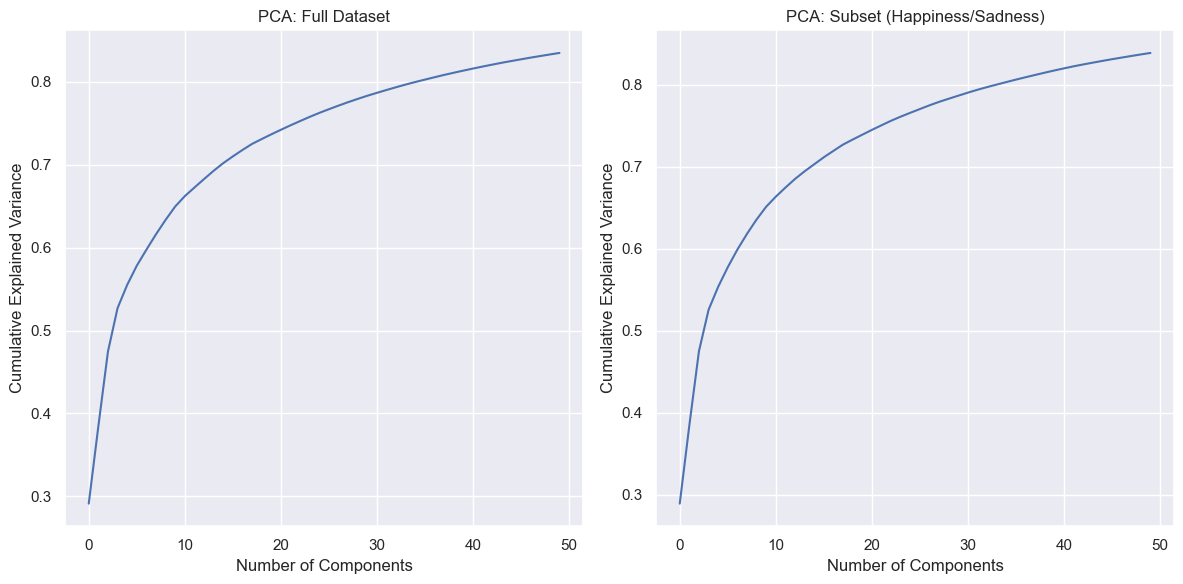

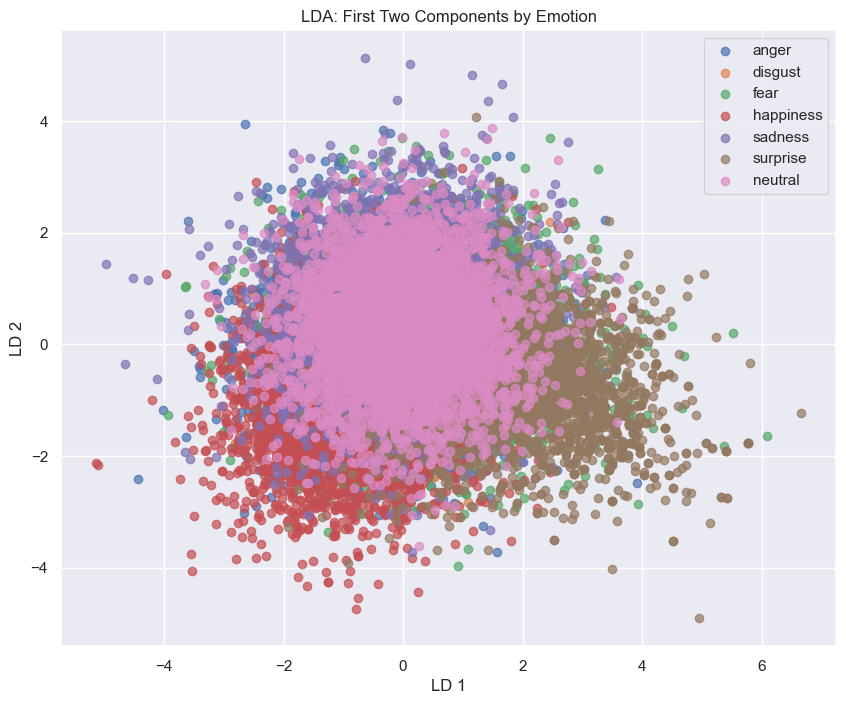

Naive Bayes Classification Report (All Emotions):
              precision    recall  f1-score   support

           0       0.16      0.34      0.22       495
           1       0.00      0.00      0.00        55
           2       0.17      0.11      0.13       512
           3       0.00      0.00      0.00       899
           4       0.18      0.65      0.28       608
           5       0.00      0.00      0.00       400
           6       0.50      0.01      0.01       620

    accuracy                           0.17      3589
   macro avg       0.14      0.16      0.09      3589
weighted avg       0.16      0.17      0.10      3589

Naive Bayes Accuracy: 0.1741432153803288


/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

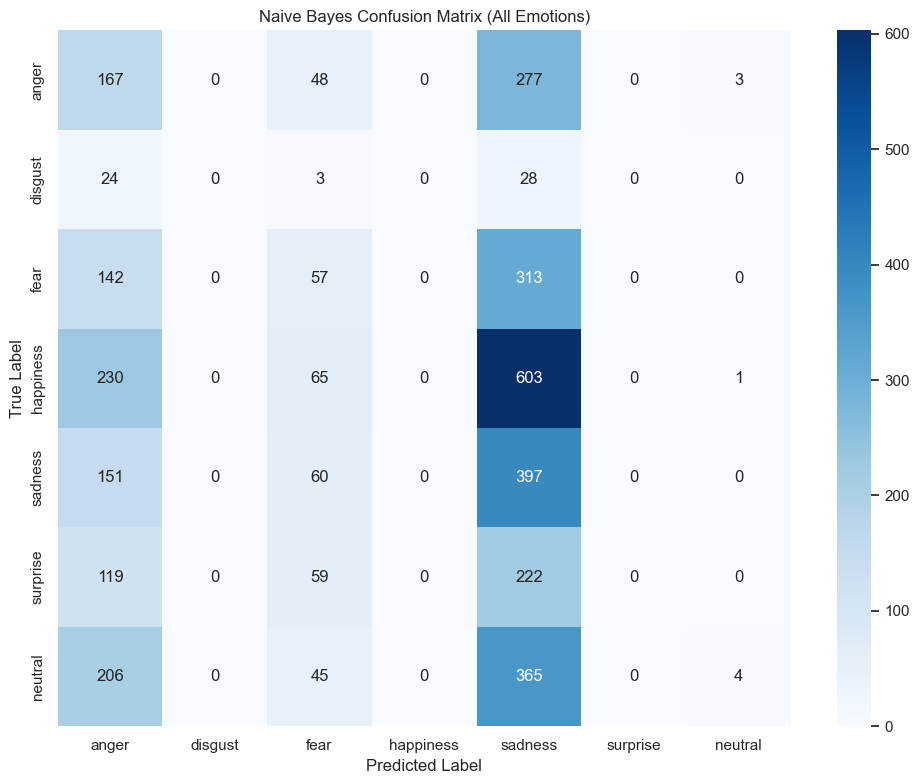

/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Classification Report (All Emotions):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       495
           1       0.03      0.09      0.04        55
           2       0.18      0.00      0.01       512
           3       0.49      0.11      0.18       899
           4       1.00      0.00      0.00       608
           5       0.12      0.98      0.22       400
           6       0.20      0.00      0.00       620

    accuracy                           0.14      3589
   macro avg       0.29      0.17      0.06      3589
weighted avg       0.37      0.14      0.07      3589

Logistic Regression Accuracy: 0.13875731401504598


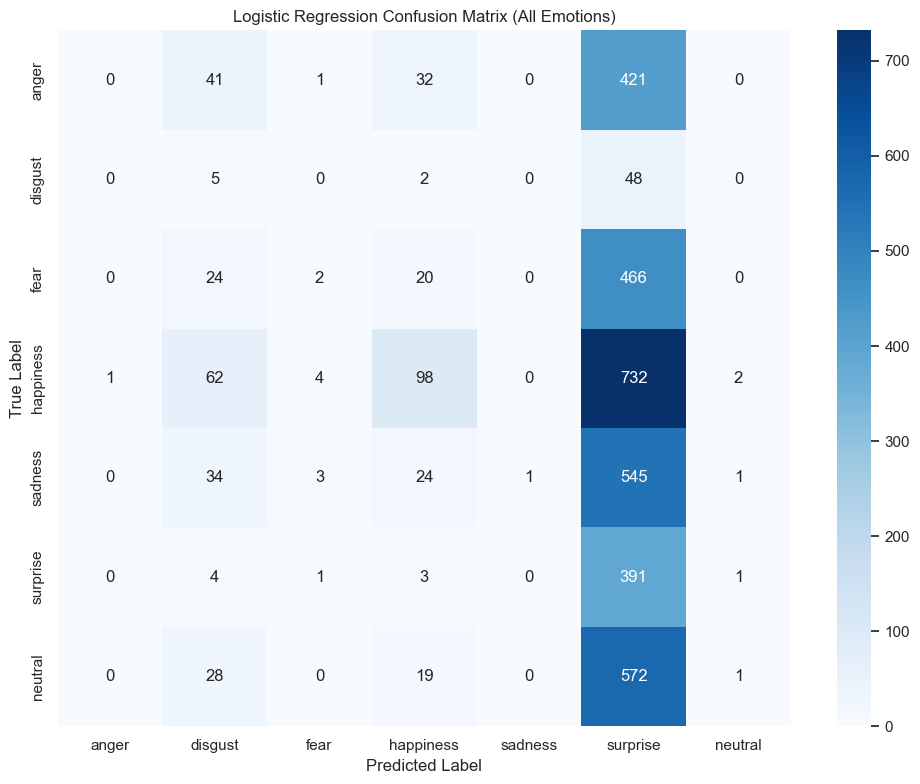

SVM Classification Report (All Emotions):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       495
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00       512
           3       0.00      0.00      0.00       899
           4       0.17      1.00      0.29       608
           5       0.00      0.00      0.00       400
           6       0.00      0.00      0.00       620

    accuracy                           0.17      3589
   macro avg       0.02      0.14      0.04      3589
weighted avg       0.03      0.17      0.05      3589

SVM Accuracy: 0.16940651992198383


/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/Desktop/school/facial-emotion/fenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

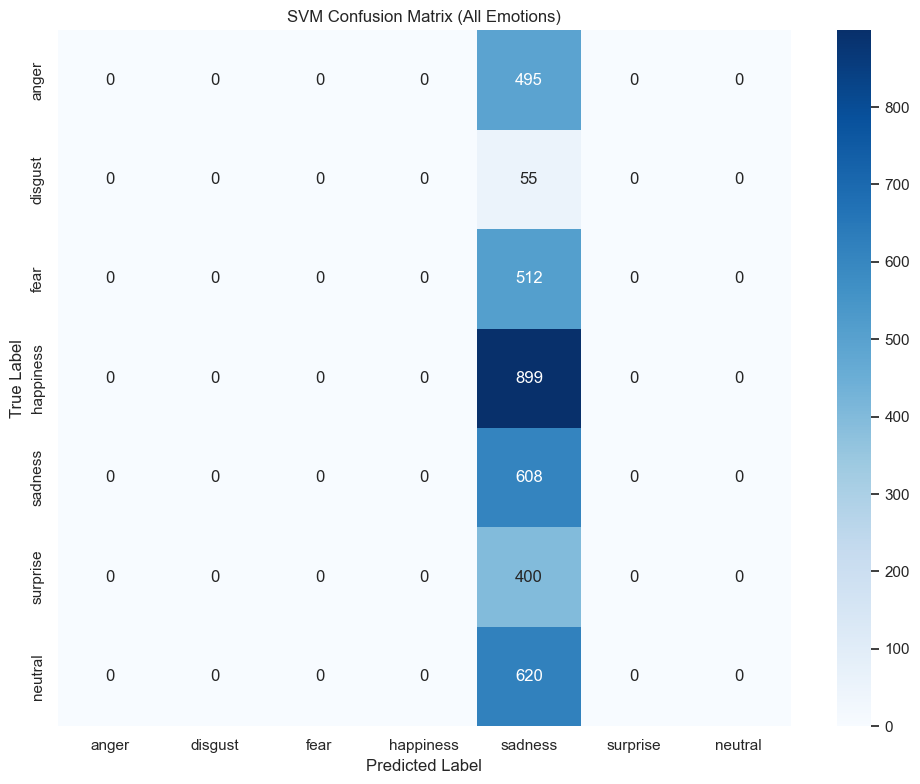

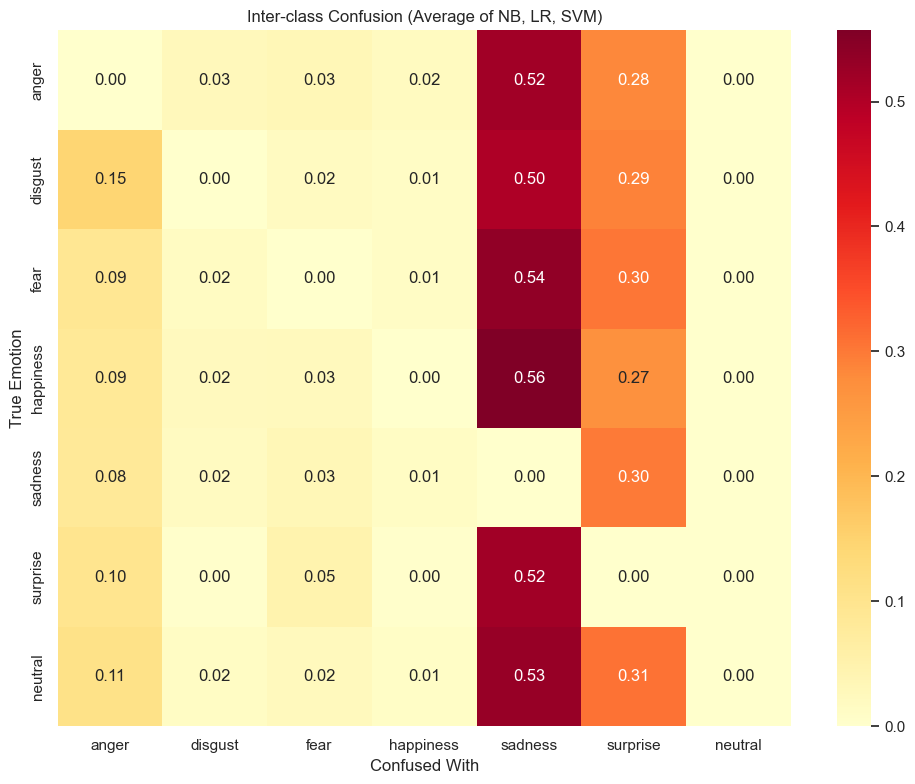

No strong candidates for mislabeled faces found.
Found 0 potentially mislabeled faces with confidence > 0.9


In [67]:
# Part II of the assignment
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Use all emotion classes for Part II
# Flatten the images for feature extraction
X_all = X_train.reshape(X_train.shape[0], -1)
y_all = np.argmax(y_train, axis=1)

X_test_all = X_test.reshape(X_test.shape[0], -1)
y_test_all = np.argmax(y_test, axis=1)

# Standardize the data
scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)
X_test_all_scaled = scaler_all.transform(X_test_all)

# Step 1: Apply PCA and LDA
# PCA analysis
n_components_all = 50
pca_all = PCA(n_components=n_components_all)
X_pca_all = pca_all.fit_transform(X_all_scaled)
X_test_pca_all = pca_all.transform(X_test_all_scaled)

# Plot the incremental gain in capturing variance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Full Dataset')
plt.grid(True)

# Compare with the subset
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Subset (Happiness/Sadness)')
plt.grid(True)
plt.tight_layout()
plt.savefig('pca_comparison.png')
plt.show()

# LDA analysis (for all emotions, we can have up to n_classes-1 components)
lda_all = LDA(n_components=min(6, len(np.unique(y_all)) - 1))  # 7 classes, so up to 6 components
X_lda_all = lda_all.fit_transform(X_all_scaled, y_all)
X_test_lda_all = lda_all.transform(X_test_all_scaled)

# Visualize the first two LDA components
plt.figure(figsize=(10, 8))
for emotion, i in emotion_label_to_text.items():
    plt.scatter(X_lda_all[y_all == emotion, 0], X_lda_all[y_all == emotion, 1],
                alpha=0.7, label=emotion_label_to_text[emotion])
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.title('LDA: First Two Components by Emotion')
plt.legend()
plt.grid(True)
plt.savefig('lda_all_emotions.png')
plt.show()

# Step 2: Naive Bayes classification
nb_classifier_all = GaussianNB()
nb_classifier_all.fit(X_pca_all, y_all)
y_pred_nb_all = nb_classifier_all.predict(X_test_pca_all)

print("Naive Bayes Classification Report (All Emotions):")
print(classification_report(y_test_all, y_pred_nb_all))
print("Naive Bayes Accuracy:", accuracy_score(y_test_all, y_pred_nb_all))

# Visualize confusion matrix for Naive Bayes
plt.figure(figsize=(10, 8))
cm_nb = confusion_matrix(y_test_all, y_pred_nb_all)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=[emotion_label_to_text[i] for i in range(7)],
            yticklabels=[emotion_label_to_text[i] for i in range(7)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Naive Bayes Confusion Matrix (All Emotions)')
plt.tight_layout()
plt.savefig('nb_confusion_matrix_all.png')
plt.show()

# Step 3: Logistic Regression classification
lr_classifier_all = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
lr_classifier_all.fit(X_pca_all, y_all)
y_pred_lr_all = lr_classifier_all.predict(X_test_pca_all)

print("Logistic Regression Classification Report (All Emotions):")
print(classification_report(y_test_all, y_pred_lr_all))
print("Logistic Regression Accuracy:", accuracy_score(y_test_all, y_pred_lr_all))

# Visualize confusion matrix for Logistic Regression
plt.figure(figsize=(10, 8))
cm_lr = confusion_matrix(y_test_all, y_pred_lr_all)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=[emotion_label_to_text[i] for i in range(7)],
            yticklabels=[emotion_label_to_text[i] for i in range(7)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix (All Emotions)')
plt.tight_layout()
plt.savefig('lr_confusion_matrix_all.png')
plt.show()

# Step 4: SVM classification
# Using a smaller C value for better generalization with multiple classes
svm_classifier_all = SVC(probability=True, C=1.0, kernel='rbf', random_state=42)
svm_classifier_all.fit(X_pca_all, y_all)
y_pred_svm_all = svm_classifier_all.predict(X_test_pca_all)

print("SVM Classification Report (All Emotions):")
print(classification_report(y_test_all, y_pred_svm_all))
print("SVM Accuracy:", accuracy_score(y_test_all, y_pred_svm_all))

# Visualize confusion matrix for SVM
plt.figure(figsize=(10, 8))
cm_svm = confusion_matrix(y_test_all, y_pred_svm_all)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[emotion_label_to_text[i] for i in range(7)],
            yticklabels=[emotion_label_to_text[i] for i in range(7)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix (All Emotions)')
plt.tight_layout()
plt.savefig('svm_confusion_matrix_all.png')
plt.show()


# Step 5: Discuss which classes are most similar/different
# Calculate similarity matrix based on misclassifications
def calculate_similarity_matrix(confusion_matrix):
    # Normalize by row totals to get percentages
    row_sums = confusion_matrix.sum(axis=1)
    normalized_cm = confusion_matrix / row_sums[:, np.newaxis]

    # The diagonal represents correct classifications, so zero it out
    np.fill_diagonal(normalized_cm, 0)

    # Now the matrix shows how often each class is mistaken for others
    return normalized_cm


# Get similarity matrices from the different models
similarity_nb = calculate_similarity_matrix(cm_nb)
similarity_lr = calculate_similarity_matrix(cm_lr)
similarity_svm = calculate_similarity_matrix(cm_svm)

# Average the similarities across models
average_similarity = (similarity_nb + similarity_lr + similarity_svm) / 3

# Visualize the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(average_similarity, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=[emotion_label_to_text[i] for i in range(7)],
            yticklabels=[emotion_label_to_text[i] for i in range(7)])
plt.xlabel('Confused With')
plt.ylabel('True Emotion')
plt.title('Inter-class Confusion (Average of NB, LR, SVM)')
plt.tight_layout()
plt.savefig('emotion_similarity_matrix.png')
plt.show()

# Step 6: Identify potentially mislabeled faces
# Approach: Use confidence scores from the best classifier (SVM) to find samples where
# the model's prediction differs from the label with high confidence

# Get probability predictions for test data
test_probs = svm_classifier_all.predict_proba(X_test_pca_all)

# Calculate confidence scores
max_probs = np.max(test_probs, axis=1)  # Highest probability for each prediction
pred_classes = np.argmax(test_probs, axis=1)  # Predicted class for each sample

# Find potentially mislabeled samples (high confidence but wrong prediction)
confidence_threshold = 0.8  # High confidence threshold
mislabeled_candidates = np.where((pred_classes != y_test_all) & (max_probs > confidence_threshold))[0]

# Let's visualize some of these potentially mislabeled faces
if len(mislabeled_candidates) > 0:
    n_samples = min(len(mislabeled_candidates), 10)  # Display up to 10 examples
    selected_indices = mislabeled_candidates[:n_samples]

    plt.figure(figsize=(15, n_samples * 2))
    for i, idx in enumerate(selected_indices):
        plt.subplot(n_samples, 1, i + 1)
        # Reshape back to the image dimensions
        img = X_test[idx].reshape(48, 48)
        plt.imshow(img, cmap='gray')
        plt.title(f"Labeled as: {emotion_label_to_text[y_test_all[idx]]}, "
                  f"Predicted as: {emotion_label_to_text[pred_classes[idx]]} "
                  f"with {max_probs[idx]:.2f} confidence")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('potential_mislabeled_faces.png')
    plt.show()
else:
    print("No strong candidates for mislabeled faces found.")


# Function to identify mislabeled examples in the dataset
def identify_mislabeled_faces(classifier, X_features, y_labels, confidence_threshold=0.8):
    """
    Identifies potentially mislabeled faces based on classifier confidence.

    Parameters:
    - classifier: Trained classifier with predict_proba method
    - X_features: Feature matrix
    - y_labels: True labels
    - confidence_threshold: Minimum confidence to consider

    Returns:
    - indices of potentially mislabeled examples
    - predicted labels
    - confidence scores
    """
    # Get probability predictions
    proba_predictions = classifier.predict_proba(X_features)

    # Get predicted class and confidence
    pred_classes = np.argmax(proba_predictions, axis=1)
    confidences = np.max(proba_predictions, axis=1)

    # Find examples where prediction differs from label with high confidence
    mislabeled_indices = np.where((pred_classes != y_labels) &
                                  (confidences > confidence_threshold))[0]

    return mislabeled_indices, pred_classes[mislabeled_indices], confidences[mislabeled_indices]


# Example usage of the function
potential_mislabeled, pred_labels, confidences = identify_mislabeled_faces(
    svm_classifier_all, X_test_pca_all, y_test_all, confidence_threshold=0.9)

print(f"Found {len(potential_mislabeled)} potentially mislabeled faces with confidence > 0.9")

In [ ]:
# # Optional part of the assignment
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import matplotlib.offsetbox as offsetbox
#
# # For the optional part, we need to:
# # - Generate 7-dimensional confidence vectors for face identity
# # - Create a 2D embedding of these confidence vectors
# # - Plot face images at their respective locations in the embedding
#
# # Step 1: Get confidence vectors for all test faces
# # Using our SVM model (or any other model that performed best)
# confidence_vectors = svm_classifier_all.predict_proba(X_test_pca_all)
#
# # Step 2: Apply t-SNE to get a 2D embedding of confidence vectors
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# embedding = tsne.fit_transform(confidence_vectors)
#
#
# # Step 3: Plot the embedding with face images
# def plot_embedding_with_faces(X_embedded, images, figsize=(20, 20), image_zoom=0.7):
#     """
#     Plot a 2D embedding with actual face images as points.
#
#     Parameters:
#     - X_embedded: 2D embedding coordinates
#     - images: original face images to display
#     - figsize: size of the figure
#     - image_zoom: zoom factor for the images
#     """
#     fig, ax = plt.subplots(figsize=figsize)
#
#     # Calculate bounds for the plot
#     x_min, x_max = np.min(X_embedded[:, 0]), np.max(X_embedded[:, 0])
#     y_min, y_max = np.min(X_embedded[:, 1]), np.max(X_embedded[:, 1])
#
#     # Add some margin
#     margin = 0.1
#     x_min -= (x_max - x_min) * margin
#     x_max += (x_max - x_min) * margin
#     y_min -= (y_max - y_min) * margin
#     y_max += (y_max - y_min) * margin
#
#     # Set the bounds
#     ax.set_xlim(x_min, x_max)
#     ax.set_ylim(y_min, y_max)
#
#     # Determine the step size for showing images (to avoid overcrowding)
#     # Show a maximum of 300 images to prevent overcrowding
#     n_images = min(300, len(X_embedded))
#     step = len(X_embedded) // n_images
#
#     # Plot the images at their embedded positions
#     for i in range(0, len(X_embedded), step):
#         # Get the face image
#         img = images[i].reshape(48, 48)
#
#         # Create an OffsetImage
#         imagebox = offsetbox.OffsetImage(img, zoom=image_zoom, cmap='gray')
#
#         # Create an AnnotationBbox
#         ab = offsetbox.AnnotationBbox(
#             imagebox,
#             (X_embedded[i, 0], X_embedded[i, 1]),
#             frameon=False,
#             pad=0.0
#         )
#
#         # Add the AnnotationBbox to the axes
#         ax.add_artist(ab)
#
#     # Set up the plot
#     ax.set_title("t-SNE Embedding of Face Images Based on Emotion Confidence", fontsize=14)
#     ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
#     ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
#     ax.grid(False)  # Remove grid for cleaner appearance
#
#     return fig, ax
#
#
# # Create the embedding visualization with faces
# fig, ax = plot_embedding_with_faces(embedding, X_test, figsize=(20, 20), image_zoom=0.5)
# plt.savefig('face_embedding_tsne.png', dpi=200, bbox_inches='tight')
# plt.show()
#
#
# # Add color coding by predicted emotion
# def plot_embedding_with_faces_colored(X_embedded, images, predictions, figsize=(20, 20), image_zoom=0.7):
#     """
#     Plot a 2D embedding with actual face images as points, colored by predicted emotion.
#
#     Parameters:
#     - X_embedded: 2D embedding coordinates
#     - images: original face images to display
#     - predictions: predicted emotion classes
#     - figsize: size of the figure
#     - image_zoom: zoom factor for the images
#     """
#     fig, ax = plt.subplots(figsize=figsize)
#
#     # Calculate bounds for the plot
#     x_min, x_max = np.min(X_embedded[:, 0]), np.max(X_embedded[:, 0])
#     y_min, y_max = np.min(X_embedded[:, 1]), np.max(X_embedded[:, 1])
#
#     # Add some margin
#     margin = 0.1
#     x_min -= (x_max - x_min) * margin
#     x_max += (x_max - x_min) * margin
#     y_min -= (y_max - y_min) * margin
#     y_max += (y_max - y_min) * margin
#
#     # Set the bounds
#     ax.set_xlim(x_min, x_max)
#     ax.set_ylim(y_min, y_max)
#
#     # Create scatterplot of all points with color coding
#     scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1],
#                          c=predictions, alpha=0.1, s=3, cmap='tab10')
#
#     # Create a legend for the emotions
#     legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
#                                   markerfacecolor=scatter.cmap,
#                                   # scatter.norm(i),
#                                   markersize=8, label=f'Emotion {i}') for i in range(len(np.unique(predictions)))]
#     ax.legend(handles=legend_elements, title="Predicted Emotion")
#
#     # Now, add the face images to the plot
#     for i in range(0, len(X_embedded), step):
#         img = images[i].reshape(48, 48)  # Assuming the face images are 48x48
#         imagebox = offsetbox.OffsetImage(img, zoom=image_zoom, cmap='gray')
#         ab = offsetbox.AnnotationBbox(imagebox, (X_embedded[i, 0], X_embedded[i, 1]), frameon=False, pad=0.0)
#         ax.add_artist(ab)
#
#     # Set up the plot
#     ax.set_title("t-SNE Embedding of Face Images Colored by Predicted Emotion", fontsize=14)
#     ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
#     ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
#     ax.grid(False)
#
#     return fig, ax
#
#
# # Plot the embedding with face images colored by predicted emotions
# # Assuming `y_pred` are the predicted labels from the classifier (e.g., SVM)
# fig, ax = plot_embedding_with_faces_colored(embedding, X_test, y_pred, figsize=(20, 20), image_zoom=0.5)
# plt.savefig('face_embedding_tsne_colored.png', dpi=200, bbox_inches='tight')
# plt.show()


In [ ]:
# Optional part of the assignment
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.offsetbox as offsetbox

# Step 1: Get confidence vectors for all test faces
# Using our SVM model (or any other model that performed best)
confidence_vectors = svm_classifier_all.predict_proba(X_test_pca_all)

# Step 2: Apply t-SNE to get a 2D embedding of confidence vectors
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedding = tsne.fit_transform(confidence_vectors)


# Step 3: Plot the embedding with face images
def plot_embedding_with_faces(X_embedded, images, figsize=(20, 20), image_zoom=0.7):
    """
    Plot a 2D embedding with actual face images as points.

    Parameters:
    - X_embedded: 2D embedding coordinates
    - images: original face images to display
    - figsize: size of the figure
    - image_zoom: zoom factor for the images
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate bounds for the plot
    x_min, x_max = np.min(X_embedded[:, 0]), np.max(X_embedded[:, 0])
    y_min, y_max = np.min(X_embedded[:, 1]), np.max(X_embedded[:, 1])

    # Add some margin
    margin = 0.1
    x_min -= (x_max - x_min) * margin
    x_max += (x_max - x_min) * margin
    y_min -= (y_max - y_min) * margin
    y_max += (y_max - y_min) * margin

    # Set the bounds
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Determine the step size for showing images (to avoid overcrowding)
    # Show a maximum of 300 images to prevent overcrowding
    n_images = min(300, len(X_embedded))
    step = len(X_embedded) // n_images  # Define the step for image placement

    # Plot the images at their embedded positions
    for i in range(0, len(X_embedded), step):
        # Get the face image
        img = images[i].reshape(48, 48)

        # Create an OffsetImage
        imagebox = offsetbox.OffsetImage(img, zoom=image_zoom, cmap='gray')

        # Create an AnnotationBbox
        ab = offsetbox.AnnotationBbox(
            imagebox,
            (X_embedded[i, 0], X_embedded[i, 1]),
            frameon=False,
            pad=0.0
        )

        # Add the AnnotationBbox to the axes
        ax.add_artist(ab)

    # Set up the plot
    ax.set_title("t-SNE Embedding of Face Images Based on Emotion Confidence", fontsize=14)
    ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
    ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
    ax.grid(False)  # Remove grid for cleaner appearance

    return fig, ax


# Create the embedding visualization with faces
fig, ax = plot_embedding_with_faces(embedding, X_test, figsize=(20, 20), image_zoom=0.5)
plt.savefig('face_embedding_tsne.png', dpi=200, bbox_inches='tight')
plt.show()


# Add color coding by predicted emotion
def plot_embedding_with_faces_colored(X_embedded, images, predictions, figsize=(20, 20), image_zoom=0.7):
    """
    Plot a 2D embedding with actual face images as points, colored by predicted emotion.

    Parameters:
    - X_embedded: 2D embedding coordinates
    - images: original face images to display
    - predictions: predicted emotion classes
    - figsize: size of the figure
    - image_zoom: zoom factor for the images
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate bounds for the plot
    x_min, x_max = np.min(X_embedded[:, 0]), np.max(X_embedded[:, 0])
    y_min, y_max = np.min(X_embedded[:, 1]), np.max(X_embedded[:, 1])

    # Add some margin
    margin = 0.1
    x_min -= (x_max - x_min) * margin
    x_max += (x_max - x_min) * margin
    y_min -= (y_max - y_min) * margin
    y_max += (y_max - y_min) * margin

    # Set the bounds
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Determine the step size for showing images (to avoid overcrowding)
    # Show a maximum of 300 images to prevent overcrowding
    n_images = min(300, len(X_embedded))
    step = len(X_embedded) // n_images  # Define the step for image placement

    # Create scatterplot of all points with color coding
    scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1],
                         c=predictions, alpha=0.1, s=3, cmap='tab10')

    # Create a legend for the emotions
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=scatter.cmap(scatter.norm(i)),
                                  markersize=8, label=f'Emotion {i}') for i in range(
        len(np.unique(predictions)))]
    ax.legend(handles=legend_elements, title="Predicted Emotion")

    # Now, add the face images to the plot
    for i in range(0, len(X_embedded), step):
        img = images[i].reshape(48, 48)  # Assuming the face images are 48x48
        imagebox = offsetbox.OffsetImage(img, zoom=image_zoom, cmap='gray')
        ab = offsetbox.AnnotationBbox(imagebox, (X_embedded[i, 0], X_embedded[i, 1]), frameon=False, pad=0.0)
        ax.add_artist(ab)

    # Set up the plot
    ax.set_title("t-SNE Embedding of Face Images Colored by Predicted Emotion", fontsize=14)
    ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
    ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
    ax.grid(False)

    return fig, ax


# y_pred_svm_all
# Get the predicted labels (y_pred) from your classifier (e.g., SVM)
# y_pred = svm_classifier_all.predict(X_test_pca_all)  # Assuming svm_classifier_all is your trained model

# Plot the embedding with face images colored by predicted emotions
fig, ax = plot_embedding_with_faces_colored(embedding, X_test, y_pred_svm_all, figsize=(20, 20), image_zoom=0.5)
plt.savefig('face_embedding_tsne_colored.png', dpi=200, bbox_inches='tight')
plt.show()
